# Logistic Regression with Tensorflow


In this notebook, I will revisit logistic regression, but implement it using tensorflow.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set the Seaborn theme
sns.set_theme()

## The Data

The logistic regression model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
#hawks = pd.read_csv("hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

I will be predicting whether a hawk is red-tailed or not red-tailed using wing and tail length, as that is what I did in my [logistic regression notebook](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/logistic_regression/logistic_regression.ipynb), finding it to be the best model of the ones I fitted. Let's see if I get similar performance using tensorflow.

In [3]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing", "Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to 1 and otherwise 0
hawks["Species_binary"] = [1 if x == "RT" else 0 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Using tensorflow

The code below creates a logistic regression model using the tensorflow API.

In [4]:
# Build the logistic regression model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)), # input layer with p features
    tf.keras.layers.Dense(1, activation='sigmoid')  # single neuron with sigmoid activation function
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs = 50, batch_size = 10)

Epoch 1/50
72/72 [==============================] - 2s 4ms/step - loss: 73.0404 - accuracy: 0.3525
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 45.2050 - accuracy: 0.3539
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 17.8532 - accuracy: 0.3258
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 2.8408 - accuracy: 0.4213
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 2.4916 - accuracy: 0.4846
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 2.3833 - accuracy: 0.5084
Epoch 7/50
72/72 [==============================] - 0s 3ms/step - loss: 2.2265 - accuracy: 0.5042
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: 2.0729 - accuracy: 0.5169
Epoch 9/50
72/72 [==============================] - 0s 4ms/step - loss: 1.9179 - accuracy: 0.5407
Epoch 10/50
72/72 [==============================] - 0s 2ms/step - loss: 1.7550 - accuracy: 0.5449
Epoch 11/50
72/7

With every epoch, the loss generally decreases while the accuracy increases.

### Performance/error analysis

Let's look at how the model performs, and compare the results to my original logistic regression model.

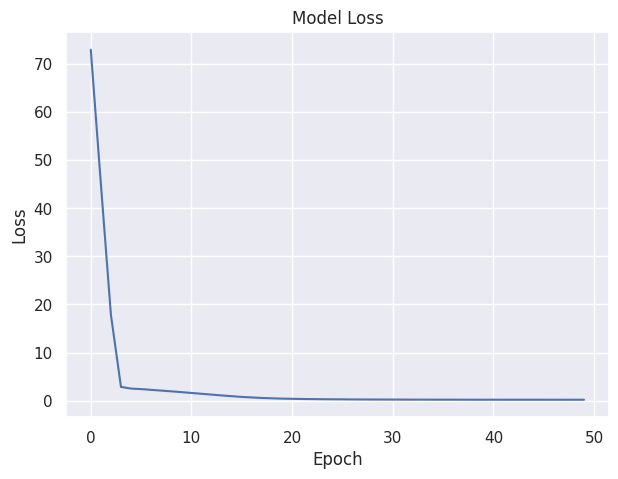

In [5]:
# Plot the loss curve
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Loss is minimized rather quickly, I could've trained for fewer epochs. But let's see how this model performs as is.

In [6]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print('Train accuracy:', train_accuracy)

23/23 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9747
Train accuracy: 0.9747191071510315


Training and testing accuracy are similar to what I had originally.

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9888
Test accuracy: 0.9888268113136292


In the output below, the array with two values correspond to the feature weights, while the array with a single value corresponds to the bias term. These weights are slightly different than what I originally got, especially the bias term.

In [8]:
# Obtain weights of each layer in the model
print(model.get_weights())

[array([[ 0.06112023],
       [-0.08734637]], dtype=float32), array([-0.5722661], dtype=float32)]


Now, let's obtain predictions on the test data to evaluate performance, comparing metrics to the original logistic regression model.

In [9]:
# Obtain predicted classes based on probabilities generated by model
predictions = np.where(model.predict(X_test) >= 0.5, 1, 0)

6/6 [==============================] - 0s 2ms/step


In [10]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



Based on the classification report, this logistic regression model performs well. There is high accuracy, precision, and recall overall. Referencing my original logistic regression notebook, the metrics are the same across the board.

We can also look at the confusion matrix.

In [11]:
def plot_RT_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, 0] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=[1, 0])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Classification Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(["RT", "Not RT"])
    ax.yaxis.set_ticklabels(["RT", "Not RT"])

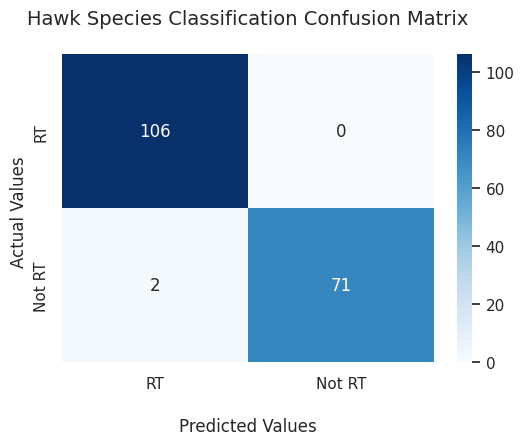

In [12]:
plot_RT_confusion_matrix(y_test, predictions)
plt.show()

I get the same confusion matrix as my logistic regression notebook!